In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
import pickle
import gzip
from tqdm import tqdm_notebook, tqdm

%matplotlib inline

# Reading dataset

In [2]:
with gzip.open('../cache/dataset.pkl.gz', 'rb') as f:
    X, y = pickle.load(f)

In [3]:
len(X), len(y)

(12202, 12202)

In [4]:
a = [x for x, y_ in zip(X, y) if y_ == 0]
b = [x for x, y_ in zip(X, y) if y_ == 1]
c = [x for x, y_ in zip(X, y) if y_ == 2]

In [6]:
c = [np.array(x) for x in c]

In [7]:
len(a), len(b), len(c)

(1835, 325, 10042)

In [8]:
from IPython.display import Audio, display

In [9]:
wids = [Audio(a[i], rate=22050) for i in np.random.randint(0, len(a), 3)]

In [10]:
for w in wids:
    display(w)

In [11]:
wids = [Audio(b[i], rate=22050) for i in np.random.randint(0, len(b), 3)]

In [12]:
for w in wids:
    display(w)

In [13]:
wids = [Audio(c[i], rate=22050) for i in np.random.randint(0, len(c), 3)]

In [14]:
for w in wids:
    display(w)

# New

In [15]:
from scipy.fftpack import fft
from scipy import signal

In [16]:
sample_rate = 22050

In [17]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [20]:
samples = c[32]

In [21]:
Audio(samples, rate=sample_rate)

In [22]:
%%timeit
freqs, times, spectrogram = log_specgram(samples, sample_rate)

669 µs ± 39.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

In [24]:
len(freqs)

221

Text(0.5,0,'Seconds')

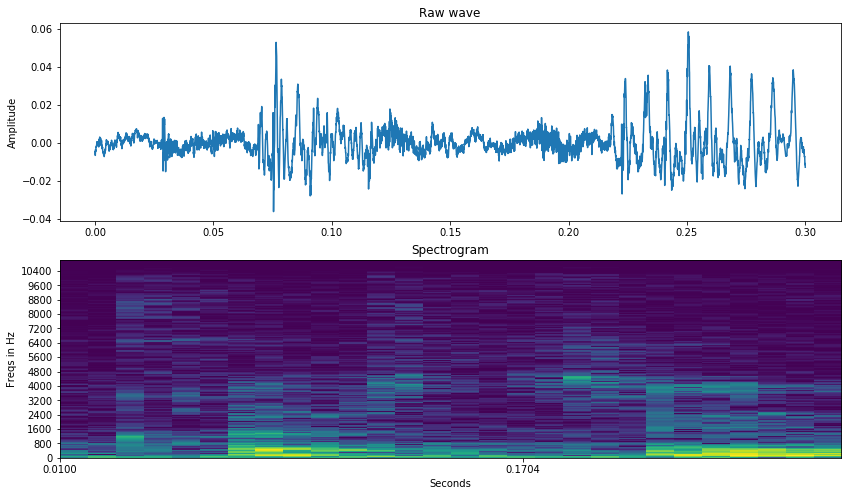

In [25]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples) / sample_rate, len(samples)), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

### Resample

https://librosa.github.io/librosa/generated/librosa.core.resample.html

In [26]:
new_sample_rate = 8000

In [27]:
%%time
samples_r = librosa.resample(samples, sample_rate, new_sample_rate)

CPU times: user 887 ms, sys: 0 ns, total: 887 ms
Wall time: 918 ms


In [28]:
%%timeit
freqs, times, spectrogram = log_specgram(samples_r, new_sample_rate)

333 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
freqs, times, spectrogram = log_specgram(samples_r, new_sample_rate)

In [30]:
len(freqs)

81

Text(0.5,0,'Seconds')

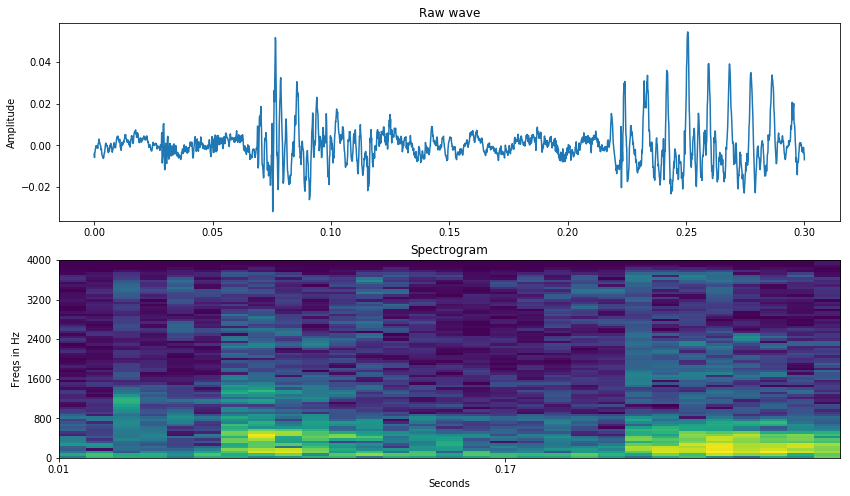

In [31]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples_r) / 8000, len(samples_r)), samples_r)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [32]:
spectrogram.shape

(29, 81)

In [33]:
Audio(samples, rate=sample_rate)

In [34]:
Audio(samples_r, rate=new_sample_rate)

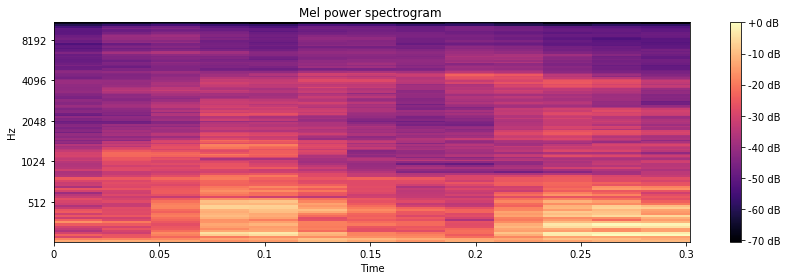

In [35]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [36]:
log_S.shape

(128, 13)

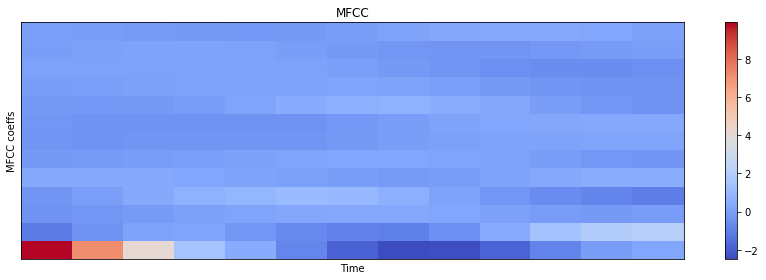

In [37]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

## FFT

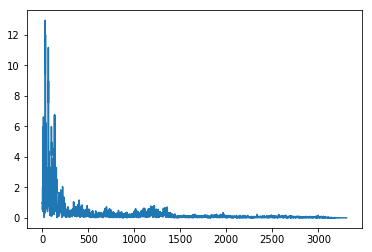

In [38]:
plt.plot(np.abs(fft(samples))[:len(samples)//2])
# plt.ylim(0, 10)

In [39]:
def custom_fft(y, fs):
#     T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
#     xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
#     vals = 2.0/N * np.abs(yf[0:N//2]) 
#     FFT is also complex, to we take just the real part (abs)
    vals = np.abs(yf[0:N//2])
    return vals

### Before and after resample

In [40]:
Audio(samples, rate=sample_rate)

In [41]:
Audio(samples_r, rate=new_sample_rate)

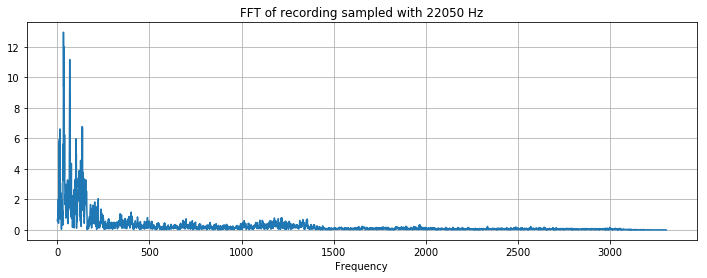

In [42]:
vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(range(len(vals)), vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

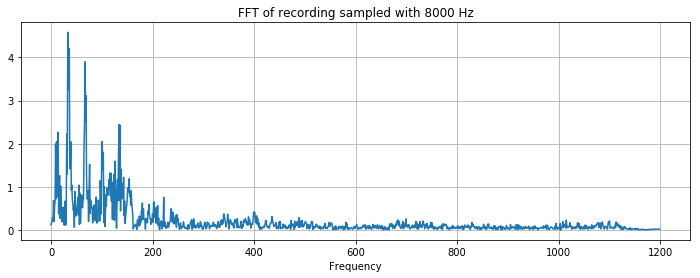

In [43]:
vals = custom_fft(samples_r, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(range(len(vals)), vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

## Different slices

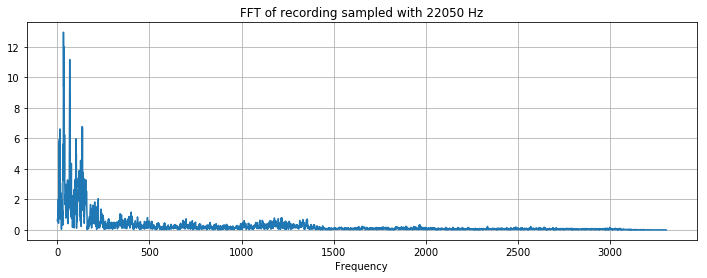

In [44]:
vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(range(len(vals)), vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

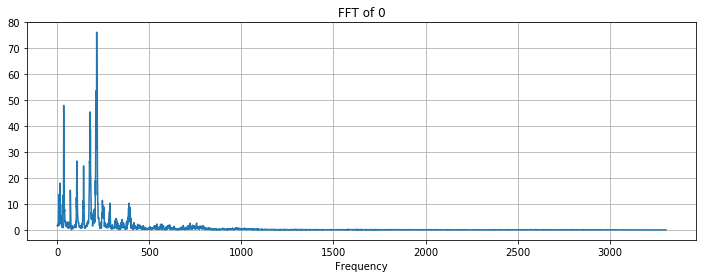

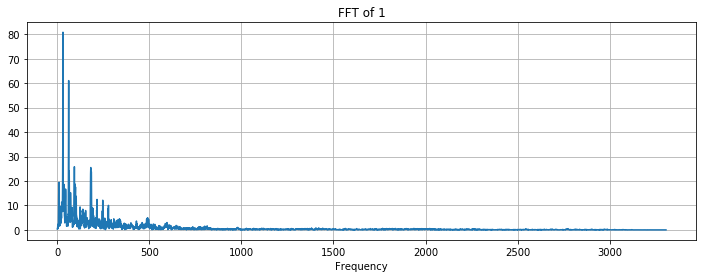

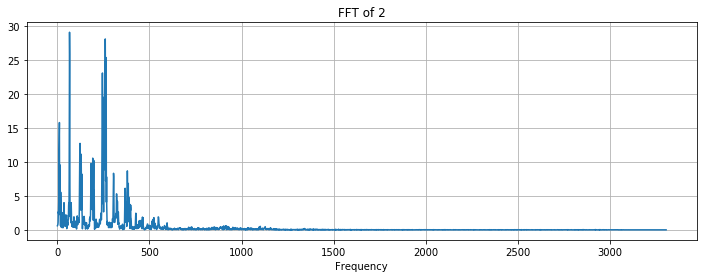

In [45]:
for i, aa in enumerate(a[:3]):
    vals = custom_fft(aa, new_sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of {}'.format(i))
    plt.plot(range(len(vals)), vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

In [46]:
Audio(a[0], rate=sample_rate)

In [47]:
Audio(a[1], rate=sample_rate)

In [48]:
Audio(a[2], rate=sample_rate)

# Feature extratction

In [49]:
X = [x if type(x) == type(np.array([])) else np.array(x) for x in X]

In [50]:
_, _, s = log_specgram(a[0], sample_rate)

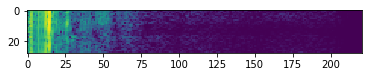

In [51]:
plt.imshow(s)

In [52]:
s.shape

(28, 221)

In [53]:
X_spec = []
for x in tqdm(X):
    _, _, spec = log_specgram(x, sample_rate)
    X_spec.append(np.expand_dims(spec, -1))
X_spec = np.array(X_spec)

100%|██████████| 12202/12202 [00:10<00:00, 1143.09it/s]


# Cnn model

In [54]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

In [55]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.utils import to_categorical

Using TensorFlow backend.
/home/evgeny/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_spec, y, test_size=0.1,
                                                    stratify=y, random_state=10)

In [57]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,
                                                    stratify=y_train, random_state=10)

In [58]:
y_train, y_val, y_test = to_categorical(y_train), to_categorical(y_val),\
                         to_categorical(y_test)

In [59]:
vc = pd.Series.value_counts(np.argmax(y_train, 1), True)
vc

2    0.822910
0    0.150374
1    0.026715
dtype: float64

In [60]:
frac = 0.75

In [62]:
vc[2] / vc[0] * frac - 1, vc[2] / vc[1] * frac - 1

(3.1043068640646032, 22.102272727272727)

In [63]:
X_train = np.vstack((X_train, np.repeat(X_train[np.argmax(y_train, 1) == 0], 3, 0)))
y_train = np.vstack((y_train, np.repeat(y_train[np.argmax(y_train, 1) == 0], 3, 0)))

In [64]:
X_train = np.vstack((X_train, np.repeat(X_train[np.argmax(y_train, 1) == 1], 22, 0)))
y_train = np.vstack((y_train, np.repeat(y_train[np.argmax(y_train, 1) == 1], 22, 0)))

In [65]:
pd.Series.value_counts(np.argmax(y_train, 1), True)

2    0.403613
1    0.301370
0    0.295017
dtype: float64

---

In [66]:
model = Sequential()
model.add(Conv2D(32, 3, input_shape=X_train[0].shape, activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

model.compile('adam', 'categorical_crossentropy')

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 219, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 109, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 107, 32)       9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 53, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 51, 32)         9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 25, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
__________

## Predict without training

In [68]:
X_val[0].shape

(28, 221, 1)

In [69]:
pr = model.predict_classes(np.array(X_val), batch_size=128, verbose=1)

1099/1099 [==============================] - 3s 3ms/step


In [70]:
pr = pr.ravel()

In [71]:
pd.Series.value_counts(pr)

1    1099
dtype: int64

In [72]:
accuracy_score(np.argmax(y_val, 1), pr)

0.026387625113739762

In [73]:
print(classification_report(np.argmax(y_val, 1), pr))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       165
          1       0.03      1.00      0.05        29
          2       0.00      0.00      0.00       905

avg / total       0.00      0.03      0.00      1099



/home/evgeny/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Training

In [74]:
pd.Series.value_counts(np.argmax(y_test, 1), True)

2    0.823096
0    0.150696
1    0.026208
dtype: float64

In [75]:
pd.Series.value_counts(np.argmax(y_train, 1), True)

2    0.403613
1    0.301370
0    0.295017
dtype: float64

In [76]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=3,
#                  class_weight={0: 15, 1: 35, 2: 1},
                 validation_data=(X_val, y_val))

Train on 20148 samples, validate on 1099 samples
Epoch 1/3
20148/20148 [==============================] - 249s 12ms/step - loss: 0.9773 - val_loss: 0.6075
Epoch 2/3
20148/20148 [==============================] - 187s 9ms/step - loss: 0.6486 - val_loss: 0.4942
Epoch 3/3
20148/20148 [==============================] - 252s 13ms/step - loss: 0.5353 - val_loss: 0.5357


In [77]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=3,
#                  class_weight={0: 15, 1: 35, 2: 1},
                 validation_data=(X_val, y_val))

Train on 20148 samples, validate on 1099 samples
Epoch 1/3
20148/20148 [==============================] - 259s 13ms/step - loss: 0.4905 - val_loss: 0.3881
Epoch 2/3
20148/20148 [==============================] - 205s 10ms/step - loss: 0.4261 - val_loss: 0.5318
Epoch 3/3
20148/20148 [==============================] - 223s 11ms/step - loss: 0.3933 - val_loss: 0.4308


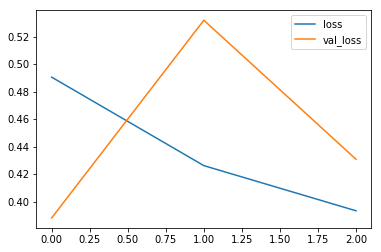

In [78]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

In [79]:
pr = model.predict_classes(X_val, batch_size=128, verbose=1)

1099/1099 [==============================] - 3s 3ms/step


In [80]:
pr = pr.ravel()

In [81]:
pd.Series.value_counts(pr)

2    741
0    232
1    126
dtype: int64

In [82]:
accuracy_score(np.argmax(y_val, 1), pr)

0.8143767060964513

In [83]:
cm = confusion_matrix(np.argmax(y_val, 1), pr)

In [84]:
cm

array([[147,   8,  10],
       [  2,  22,   5],
       [ 83,  96, 726]])

In [99]:
print(classification_report(np.argmax(y_val, 1), pr))

             precision    recall  f1-score   support

          0       0.55      0.78      0.64        60
          1       0.24      0.80      0.37        25
          2       0.98      0.89      0.93       904

avg / total       0.94      0.88      0.90       989



In [85]:
print(classification_report(np.argmax(y_val, 1), pr))

             precision    recall  f1-score   support

          0       0.63      0.89      0.74       165
          1       0.17      0.76      0.28        29
          2       0.98      0.80      0.88       905

avg / total       0.91      0.81      0.85      1099



In [87]:
%time model.predict(X_val[:10, :, :, :])

CPU times: user 70.8 ms, sys: 3.9 ms, total: 74.7 ms
Wall time: 31.4 ms


array([[  9.33777273e-01,   1.14163384e-03,   6.50810376e-02],
       [  4.98994632e-05,   4.15613176e-05,   9.99908566e-01],
       [  2.00370520e-01,   4.50942554e-02,   7.54535198e-01],
       [  1.30511820e-02,   1.43651202e-01,   8.43297660e-01],
       [  4.56769496e-01,   4.24538851e-02,   5.00776649e-01],
       [  1.72208610e-03,   1.31984306e-02,   9.85079527e-01],
       [  9.80439246e-01,   6.02647848e-03,   1.35343000e-02],
       [  1.00676104e-01,   2.99726501e-02,   8.69351208e-01],
       [  2.43428032e-04,   2.80269748e-03,   9.96953845e-01],
       [  1.07711775e-03,   2.50323974e-02,   9.73890543e-01]], dtype=float32)

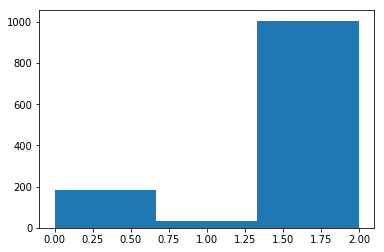

In [88]:
plt.hist(np.argmax(y_test, 1), bins=3);

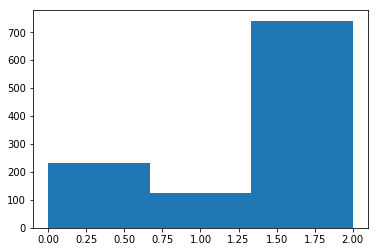

In [89]:
plt.hist(pr, bins=3);

In [88]:
accuracy_score(np.argmax(y_test, 1), [2] * len(y_test))

0.913557779799818

In [89]:
model.get_weights()[0].shape

(3, 3, 1, 32)

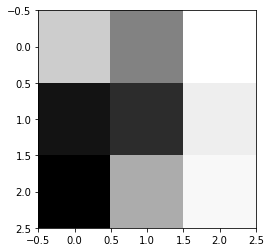

In [90]:
plt.imshow(model.get_weights()[0][:, :, 0, 4])
plt.gray()

# Testing on new data

In [78]:
def get_praat_annotations(paths):
    dfs = []
    for path in paths:
        with open(path) as f:
            annotation = [l.strip() for l in f.readlines()]
            
        indxs = [i for i, l in enumerate(annotation) if l == '"IntervalTier"']
        annotation = annotation[indxs[0] + 5:indxs[1] if len(indxs) > 1\
                                else len(annotation)]
        annotation_dicts = []

        for s, e, l in zip(annotation[0::3], annotation[1::3], annotation[2::3]):
            annotation_dicts.append({
                'start': float(s),
                'finish': float(e),
                'label': l.replace('"', ''),
                'length': float(e) - float(s)
            })
        df = pd.DataFrame(annotation_dicts)
        dfs.append(df)
    return dfs

test_annotation = get_praat_annotations(['../annotations/arhis1.TextGrid'])

In [79]:
test_audio, sr = librosa.load('../audio/arhis1.m4a')

In [80]:
interval_time = 0.1
interval_step = 0.05

interval_len, step_len = librosa.time_to_samples(interval_time)[0],\
                 librosa.time_to_samples(interval_step)[0]

In [81]:
interval_len, step_len

(2205, 1102)

In [82]:
def get_label_data(annotation, audio, labels, sr=22050):
    # по дефолту все 2го класса
    data = pd.Series(index=np.arange(0, len(audio) - interval_len, step_len), data=2)
    label_map = {'a': 0, 'b': 1, 'c': 2}
    for label in labels:
        l = label_map[label]
        start_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                              label].start.values, sr)
        finish_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                               label].finish.values, sr)
        for s, f in zip(start_samples_indxs, finish_samples_indxs):
            s = int(np.round(s / step_len)) * step_len
            f = (int(np.round(f / step_len)) - 2) * step_len
            # вычитаем 2 потому что f - это конец интервала, в Series мы заносим метку для 
            # начала  интервала, длина интервала 2 * step, поэтому нужно вычесть 2
            data[(data.index >= s) & (data.index <= f)] = l
    return data

In [83]:
test_data = get_label_data(test_annotation[0], test_audio, ['a', 'b'])

In [84]:
test_data.shape

(6346,)

In [85]:
test_data.value_counts()

2    6002
0     344
dtype: int64

In [86]:
test_data = test_data.replace({2: 1})

In [87]:
test_data.value_counts(True)

1    0.945793
0    0.054207
dtype: float64

In [88]:
test_samples = [test_audio[i:i + interval_len] for i in test_data.index]

In [89]:
test_samples[0].shape

(2205,)

In [90]:
len(test_samples)

6346

In [91]:
%%time
test_features = np.stack([extract_feature(x) for x in tqdm(test_samples)])

100%|██████████| 6346/6346 [07:12<00:00, 14.66it/s]

CPU times: user 7min 9s, sys: 2.98 s, total: 7min 12s
Wall time: 7min 12s


In [92]:
test_predict = model.predict_classes(test_features, batch_size=128)

In [93]:
test_predict_pr = model.predict_proba(test_features, batch_size=128)

In [94]:
accuracy_score(test_data.values, test_predict) # c 2мя cnn

0.95004727387330601

In [133]:
accuracy_score(test_data.values, [1] * len(test_predict))

0.94579262527576424

In [95]:
print(classification_report(test_data.values, test_predict)) # cnn

             precision    recall  f1-score   support

          0       0.64      0.18      0.28       344
          1       0.95      0.99      0.97      6002

avg / total       0.94      0.95      0.94      6346



In [ ]:
# test_predict_new = 1 * (test_predict_pr[:, 1] > 0.95).astype(int)

In [98]:
test_predict_new = 1 * (test_predict_pr > 0.9).astype(int)

In [99]:
print(classification_report(test_data.values, test_predict_new))

             precision    recall  f1-score   support

          0       0.24      0.65      0.36       344
          1       0.98      0.88      0.93      6002

avg / total       0.94      0.87      0.90      6346



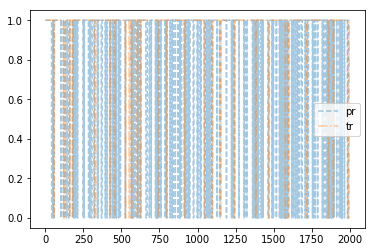

In [100]:
plt.plot(test_predict_new[:2000], '--', label='pr', alpha=0.4)
plt.plot(test_data.iloc[:2000].values, '-.', label='tr', alpha=0.4)
plt.legend()

## Отображение результата

In [108]:
from PIL import Image
import os
import shutil

In [289]:
# os.rmdir('../cache/imgs/')
shutil.rmtree('../cache/imgs/')

In [290]:
os.mkdir('../cache/imgs')

In [291]:
for i, (r, t) in enumerate(zip(test_predict_new, test_data.values)):
    im_r = np.zeros((32, 64, 3), dtype='uint8')
    if r == 0:
        im_r[:,:,0] = 255
    elif r == 1:
        im_r[...,2] = 255
    else:
        im_r[...,1] = 255
        
    im_t = np.zeros((32, 64, 3), dtype='uint8')
    if t == 0:
        im_t[:,:,0] = 255
    elif t == 1:
        im_t[...,2] = 255
    else:
        im_t[...,1] = 255
        
    im = np.vstack((im_r, im_t))
    im = Image.fromarray(im)
    im.save('../cache/imgs/test_{:04d}.png'.format(i + 2))
im.save('../cache/imgs/test_{:04d}.png'.format(0))
im.save('../cache/imgs/test_{:04d}.png'.format(1))

In [292]:
os.system('ffmpeg -r 20 -i ../cache/imgs/test_%04d.png -i ../audio/arhis1.mp3 -vcodec mpeg4 -y ../cache/a.mp4')

0

## Ручная корректировка шума

In [101]:
test_predict_new = test_predict_new.ravel()

In [102]:
%%time
test_predict_new2 = []

start = False
for t, tn in zip(test_predict_new, np.append(test_predict_new[1:], [1])):
    if t == 0 and tn == 0 and not start:
        # если встретили 0 и следующий 0 и до этого не началось, включаем начало и доб-ем 0
        start = True
        test_predict_new2.append(0)
    elif t == 0 and tn == 0 and start:
        # если встретили 0 и следующий 0 и до этого началось, доб-ем 0 - мы в серии нулей
        test_predict_new2.append(0)
    elif t == 0 and tn != 0 and not start:
        # если встретили 0, а следующий не 0 и до этого не началось, значит шум, не 0 
        test_predict_new2.append(1)
    elif t == 0 and tn != 0 and start:
        # если встретили 0, а след. не 0 и до этого началось, значит 0, но начало в False
        start = False
        test_predict_new2.append(0)
    elif t == 1:
        # если встрили 1, добавляем 1
        test_predict_new2.append(1)
        start = False
    else:
        print(t, tn, start)

CPU times: user 7.93 ms, sys: 0 ns, total: 7.93 ms
Wall time: 7.9 ms


In [103]:
pd.Series.value_counts(test_predict_new)

1    5424
0     922
dtype: int64

In [104]:
pd.Series.value_counts(test_predict_new2)

1    5604
0     742
dtype: int64

In [105]:
print(classification_report(test_data.values, test_predict_new))

             precision    recall  f1-score   support

          0       0.24      0.65      0.36       344
          1       0.98      0.88      0.93      6002

avg / total       0.94      0.87      0.90      6346



In [106]:
print(classification_report(test_data.values, test_predict_new2))

             precision    recall  f1-score   support

          0       0.30      0.64      0.41       344
          1       0.98      0.91      0.94      6002

avg / total       0.94      0.90      0.92      6346



Precision поднялся на 0.07, а recall упал лишь на 0.01

## Отображение результата

In [109]:
shutil.rmtree('../cache/imgs/')

In [110]:
os.mkdir('../cache/imgs')

In [111]:
for i, (r, t) in enumerate(zip(test_predict_new2, test_data.values)):
    im_r = np.zeros((32, 64, 3), dtype='uint8')
    if r == 0:
        im_r[:,:,0] = 255
    elif r == 1:
        im_r[...,2] = 255
    else:
        im_r[...,1] = 255
        
    im_t = np.zeros((32, 64, 3), dtype='uint8')
    if t == 0:
        im_t[:,:,0] = 255
    elif t == 1:
        im_t[...,2] = 255
    else:
        im_t[...,1] = 255
        
    im = np.vstack((im_r, im_t))
    im = Image.fromarray(im)
    im.save('../cache/imgs/test_{:04d}.png'.format(i + 2))
im.save('../cache/imgs/test_{:04d}.png'.format(0))
im.save('../cache/imgs/test_{:04d}.png'.format(1))

In [112]:
os.system('ffmpeg -r 20 -i ../cache/imgs/test_%04d.png -i ../audio/arhis1.mp3 -vcodec mpeg4 -y ../cache/aa.mp4')

0